In [1]:
import tensorflow as tf
import numpy as np

In [2]:
BATCH_SIZE = 128
IMG_SIZE = (224, 224)

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory('data/train', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory('data/val', shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 1004 files belonging to 2 classes.
Found 376 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names

In [5]:
# Split the validation set to create a test set

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 3
Number of test batches: 0


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV3Small(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
# converts each image into a 5x5x1280 block of features
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(128, 7, 7, 576)


In [11]:
base_model.trainable = False

base_model.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                   

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(128, 576)


In [13]:
middle_layer = tf.keras.layers.Dense(576, activation='relu')
middle_batch = middle_layer(feature_batch_average)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(middle_batch)
print(prediction_batch.shape)

(128, 1)


In [14]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 577   

## Compiling the Model

In [16]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [17]:
initial_epochs = 5

loss0, accuracy0 = model.evaluate(validation_dataset)

3/3 [==============================] - 4s 535ms/step - loss: 0.7939 - accuracy: 0.4574


In [18]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.79
initial accuracy: 0.46


In [19]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/5


8/8 [==============================] - 20s 2s/step - loss: 0.8376 - accuracy: 0.4731 - val_loss: 0.7861 - val_accuracy: 0.4707
Epoch 2/5
8/8 [==============================] - 14s 2s/step - loss: 0.8324 - accuracy: 0.4781 - val_loss: 0.7798 - val_accuracy: 0.4734
Epoch 3/5
8/8 [==============================] - 14s 2s/step - loss: 0.8351 - accuracy: 0.4871 - val_loss: 0.7743 - val_accuracy: 0.4707
Epoch 4/5
8/8 [==============================] - 14s 2s/step - loss: 0.7932 - accuracy: 0.4990 - val_loss: 0.7691 - val_accuracy: 0.4734
Epoch 5/5
8/8 [==============================] - 15s 2s/step - loss: 0.8095 - accuracy: 0.4950 - val_loss: 0.7641 - val_accuracy: 0.4814


## Learning Curves

In [20]:
import matplotlib.pyplot as plt

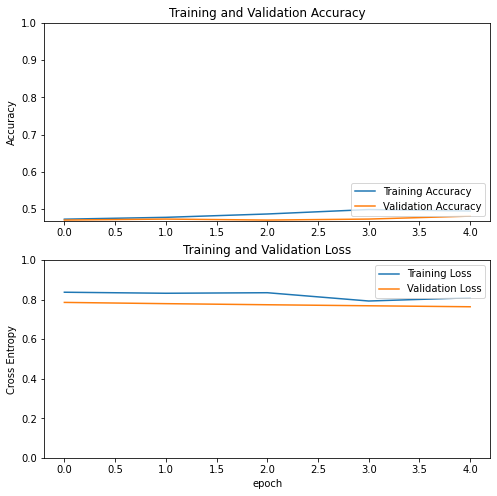

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning

In [22]:
base_model.trainable = True

In [23]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  229


In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/3),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 577   

In [26]:
# Continue training the model

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 5/55


8/8 [==============================] - 35s 2s/step - loss: 0.7817 - accuracy: 0.5060 - val_loss: 0.7071 - val_accuracy: 0.5426
Epoch 6/55
8/8 [==============================] - 17s 2s/step - loss: 0.7041 - accuracy: 0.5618 - val_loss: 0.6842 - val_accuracy: 0.5691
Epoch 7/55
8/8 [==============================] - 17s 2s/step - loss: 0.6731 - accuracy: 0.6135 - val_loss: 0.6652 - val_accuracy: 0.6090
Epoch 8/55
8/8 [==============================] - 17s 2s/step - loss: 0.6470 - accuracy: 0.6335 - val_loss: 0.6492 - val_accuracy: 0.6090
Epoch 9/55
8/8 [==============================] - 17s 2s/step - loss: 0.6283 - accuracy: 0.6484 - val_loss: 0.6360 - val_accuracy: 0.6330
Epoch 10/55
8/8 [==============================] - 17s 2s/step - loss: 0.6015 - accuracy: 0.6624 - val_loss: 0.6213 - val_accuracy: 0.6463
Epoch 11/55
8/8 [==============================] - 17s 2s/step - loss: 0.5846 - accuracy: 0.6873 - val_loss: 0.6097 - val_accuracy: 0.6622
Epoch 12/55
8/8 [==========================

In [27]:
# Looking at the learning curves of the model
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

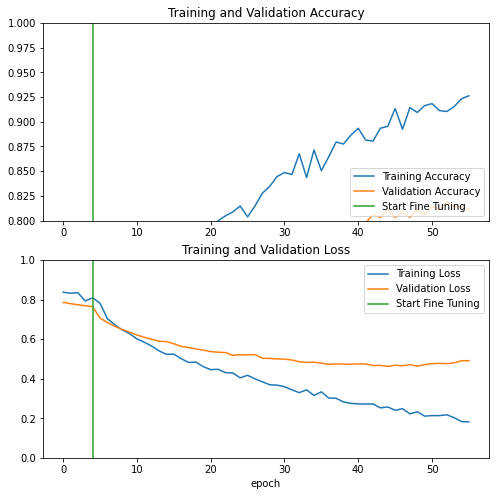

In [28]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
# Saving the model
model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
model.save("model4.h5")

## Further Training

In [30]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 MobilenetV3small (Functiona  (None, 7, 7, 576)        939120    
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 576)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 576)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 577   

In [31]:
# Continue training the model

fine_tune_epochs = 45
furhter_training_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs + furhter_training_epochs

history_further = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_fine.epoch[-1],
                         validation_data=validation_dataset)

Epoch 55/70


8/8 [==============================] - 35s 2s/step - loss: 0.1809 - accuracy: 0.9323 - val_loss: 0.4915 - val_accuracy: 0.8218
Epoch 56/70
8/8 [==============================] - 18s 2s/step - loss: 0.1809 - accuracy: 0.9243 - val_loss: 0.4875 - val_accuracy: 0.8218
Epoch 57/70
8/8 [==============================] - 18s 2s/step - loss: 0.1675 - accuracy: 0.9293 - val_loss: 0.4913 - val_accuracy: 0.8165
Epoch 58/70
8/8 [==============================] - 18s 2s/step - loss: 0.1562 - accuracy: 0.9422 - val_loss: 0.4915 - val_accuracy: 0.8245
Epoch 59/70
8/8 [==============================] - 18s 2s/step - loss: 0.1617 - accuracy: 0.9343 - val_loss: 0.4961 - val_accuracy: 0.8191
Epoch 60/70
8/8 [==============================] - 18s 2s/step - loss: 0.1563 - accuracy: 0.9373 - val_loss: 0.4965 - val_accuracy: 0.8191
Epoch 61/70
8/8 [==============================] - 18s 2s/step - loss: 0.1556 - accuracy: 0.9412 - val_loss: 0.4958 - val_accuracy: 0.8245
Epoch 62/70
8/8 [======================

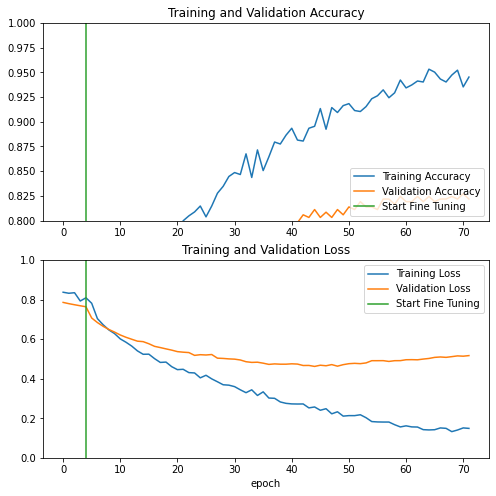

In [32]:
# Looking at the learning curves of the model
acc += history_further.history['accuracy']
val_acc += history_further.history['val_accuracy']

loss += history_further.history['loss']
val_loss += history_further.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
# Saving the model
model_json = model.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model_json)
model.save("model4.h5")